# DC Motor

This notebook models a DC motor based on equations presented [here](https://ctms.engin.umich.edu/CTMS/index.php?example=MotorSpeed&section=SystemModeling) and [here](https://ctms.engin.umich.edu/CTMS/index.php?example=MotorSpeed&section=SystemAnalysis).

Additional explanation on the motor are presented [here](https://www.youtube.com/watch?v=leMleP_Q5gs)

More information can be found:

- [DC Motor Transfer Function | Multidisciplinary Engineering @ RIT](http://edge.rit.edu/edge/P14453/public/Research/DC%20Motor%20Transfer%20Function%20Example.pdf)

- [DC Motor Transfer Function | 438A](https://www.engr.siu.edu/staff/spezia/Web438A/Lecture%20Notes/lesson14et438a.pdf)

In [ ]:
#| default_exp dc_motor

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import defaultdict
import time 

from feedback_control.simple_pendulum import *

In [ ]:
#| include: false
from IPython.display import Image
from IPython.display import HTML

from matplotlib import rc

In [ ]:
#| hide
# This is equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [ ]:
#| include: false
# %matplotlib notebook

---------------

In [ ]:
#| export
class DCMotorParams():
    def __init__(self, J=0.01, b=0.1, K=0.01, R=1, L=0.5):
            #     (J)     moment of inertia of the rotor     0.01 kg.m^2
            #     (b)     motor viscous friction constant    0.1 N.m.s
            #     (Ke)    electromotive force constant       0.01 V/rad/sec
            #     (Kt)    motor torque constant              0.01 N.m/Amp
            #     (R)     electric resistance                1 Ohm
            #     (L)     electric inductance                0.5 H
            #     Note that in SI units, Ke = Kt = K
        self.J = J
        self.b = b
        self.K = K
        self.R = R
        self.L = L
                
class DCMotor():
    def __init__(self, x0, params):
        self._params  = params
                
        self._x0 = x0
        self._x = x0
        self._J_load = 0
        self.update_motor_matrix()
        
    def update_motor_matrix(self):
        # state variables are: rotation speed (w, or theta_dot) and current (i)
        self._A = np.array([[-self._params.b/(self._params.J+self._J_load),  self._params.K/(self._params.J+self._J_load)],
                            [-self._params.K/self._params.L,  -self._params.R/self._params.L]])
        self._B = np.array([[0],[1/self._params.L]])
        self._C = np.array([1,   0])
        self._D = 0;
        
    def reset(self):
        self._x = self._x0
        
    def set_load(self, J_load):
        self._params.J += J_load   
        self.update_motor_matrix()
        
    def step(self, dt, u):
        self._x = self._x + dt*(self._A@self._x + self._B*u)
              
    def measure_speed(self):
        self._y = self._C@self._x 
        return self._y

In [ ]:
motor = DCMotor(np.array([[0], [0]]), DCMotorParams())

In [ ]:
y = []
u = 1 # input

time_vector = np.arange(0, 10, 0.01)
for t in time_vector:
    motor.step(0.01, u)
    y.append(motor.measure_speed())  

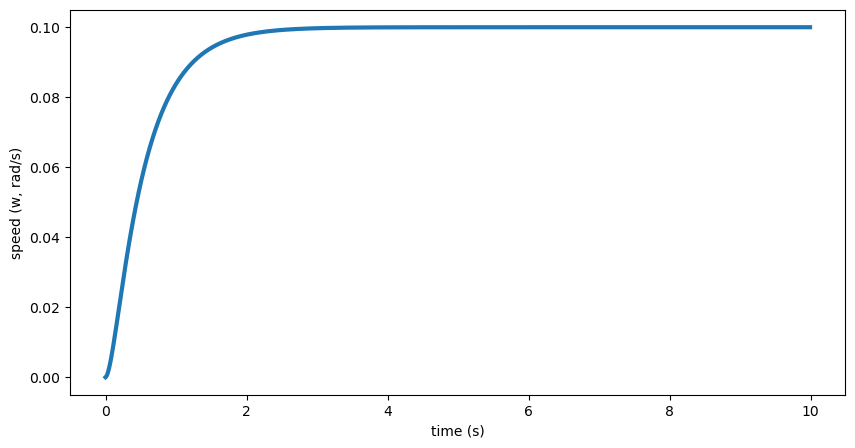

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.plot(time_vector, y, linewidth=3)
plt.xlabel('time (s)')
plt.ylabel('speed (w, rad/s)');

Now we can add a load on the motor to verify how it changes the response

In [ ]:
motor.reset()
motor.set_load(0.1)

In [ ]:
y = []
u = 1 # input (Volts)

time_vector = np.arange(0, 10, 0.01)
for t in time_vector:
    motor.step(0.01, u)
    y.append(motor.measure_speed())    

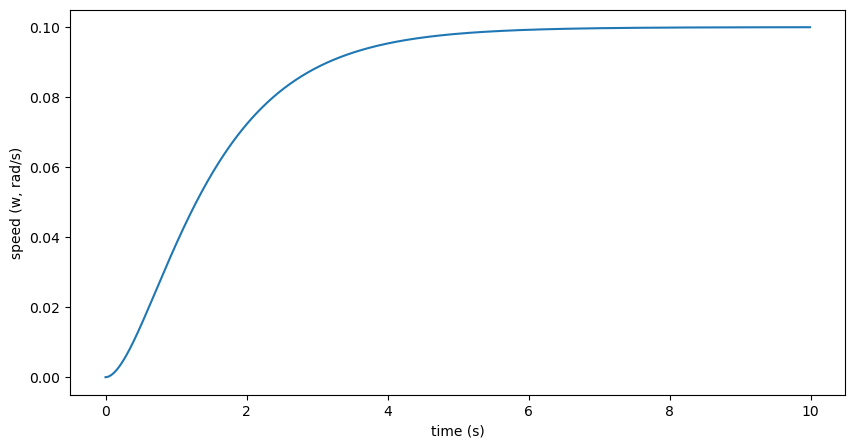

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.plot(time_vector, y)
plt.xlabel('time (s)')
plt.ylabel('speed (w, rad/s)');

As expected, given than now we have a higher load the motor takes more time to get to its steady state.

### Extended DCMotor

The `DCMotor` defined in the previous class does not include the rotor's position in its state. We are going to slighlty modify the equations to add one state to explicit the rotor's position.

This is the class that we export in our library.

We also define a wrapping function to make sure the rotor position stays within $[-\pi,\pi]$.

In [ ]:
#| export
def wrap(angle):
    "Wraps an angle between -pi and pi."
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [ ]:
#| export
class DCMotorParams():
    def __init__(self, 
                 J=0.01, 
                 b=0.1, 
                 K=0.01, 
                 R=1, 
                 L=0.5):
        self.J = J #     (J)     moment of inertia of the rotor     0.01 kg.m^2
        self.b = b #     (b)     motor viscous friction constant    0.1 N.m.s
        self.K = K #     (Ke)    electromotive force constant       0.01 V/rad/sec
                   #     (Kt)    motor torque constant              0.01 N.m/Amp
        self.R = R #     (R)     electric resistance                1 Ohm
        self.L = L #     (L)     electric inductance                0.5 H

In [ ]:
#| export 
class DCMotor():
    """DCMotor implements a direct current motor."""
    def __init__(self, x0, params):
        self._params  = params
                
        self._x0 = x0
        self._x = x0
        self._J_load = 0
        self._update_motor_matrix()
        
        self._load = False
        
    def _update_motor_matrix(self):
        # state variables are: position (theta), rotation speed (w, or theta_dot) and current (i)
        self._A = np.array([
            [0, 1, 0],
            [0, -self._params.b/(self._params.J+self._J_load),  self._params.K/(self._params.J+self._J_load)],
            [0, -self._params.K/self._params.L,  -self._params.R/self._params.L]
            ])
        self._B = np.array([[0],[0],[1/self._params.L]])
        self._C = np.array([
            [1, 0, 0], # position
            [0, 1, 0]  # velocity
        ])
        self._D = 0;
        
    def step(self, dt, u):
        """Runs one step of the motor model, and outputs the resulting torque."""
        self._x = self._x + dt*(self._A@self._x + self._B*u)                
        self._x[0] = wrap(self._x[0]) # wrap theta to stay between -pi and pi        
        torque = self._params.K*self._x[1,0] # motor torque
        return torque
    
    def reset(self):
        self._x = self._x0
        
    def set_load_parameters(self, J_load):
        self._params.J += J_load   
        self.update_motor_matrix()
        
    def connect_to(self, load):
        self._load = load
        self._params.J = load.moment_of_inertia()   
        self._update_motor_matrix()
            
    def _output_equation(self):
        return self._C@self._x         
    
    def measure(self):
        # We need to move this function out of the DCMotor class.        
        return np.array([[self._load.position()], [self._load.speed()]]) \
                        if self._load else self._output_equation()                

    
    
    def get_motor_torque(self):
        """the motor torque is proportional to only the armature current `i` by a constant factor `K`: T=K*i"""
        return self._params.K*self._x[1,0]

In [ ]:
motor = DCMotor(x0=np.array([[0], [0], [0]]), params=DCMotorParams())
y = np.array([[0],[0]]) # initialise to 0. This is only here to have the correct size. Alternative: y = np.empty((2,1)) 

u = 1 # input

time_vector = np.arange(0, 10, 0.01)
for t in time_vector:
    motor.step(0.01, u)
    y = np.append(y, motor.measure(), axis=1)   
    
# remove the first item which was there only to have the correct size
y = np.delete(y, 0, axis=1)

position = y[0,:]
velocity = y[1,:]

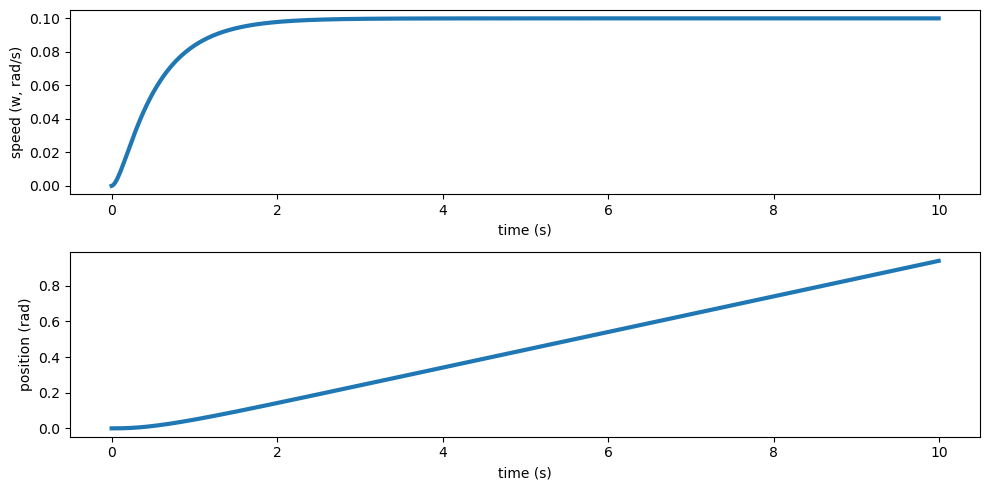

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,5))

axs[0].plot(time_vector, velocity, linewidth=3)
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('speed (w, rad/s)')

axs[1].plot(time_vector, position, linewidth=3)
axs[1].set_xlabel('time (s)')
axs[1].set_ylabel('position (rad)');

plt.tight_layout()

### DC Motor Transfer Function

Or if we want to express it as a transfer function:
$$ 
P(s) = \frac{\dot\Theta(s)}{V(s)} = \frac{K}{(Js+b)(Ls+R) + K^2}
$$

and if we want to measure the position

$$ 
\tilde{P}(s) = \frac{\Theta(s)}{V(s)} = \frac{K}{s(Js+b)(Ls+R) + K^2}
$$

## Adding a motor controller

The next step is to have a motor controller so that we can use it in our workspace.

In [ ]:
#| export
class PID():
    """PID controller."""
    def __init__(self, Kp, Kd, Ki):  
        self.Kp = Kp
        self.Kd = Kd
        self.Ki = Ki
        self._error_old = 0
        self._error_I  = 0
        
    def control(self, dt, y_des, y):
        """Controls position to a desired (y_des) value. 
        Inputs: 
          - dt: seconds (sampling time)
          - y_des: m (desired value)
          - y: m (measured value)
        """
        # apply controller
        error = y_des - y
        error_dot = (error - self._error_old)/dt
        self._error_I   += error*dt
        self._error_old = error
        # controller
        return self.Kp*error + self.Kd*error_dot + self.Ki*self._error_I
            

In [ ]:
pendulum = Pendulum(theta_0=np.radians(0), 
                    theta_dot_0=0, 
                    params=PendulumParameters(b=0.2))

motor = DCMotor(x0=np.array([[0], [0], [0]]), 
                params=DCMotorParams())

pid = PID(Kp=1000, 
          Kd=500, 
          Ki=1000)

# connect the motor to the pendulum
motor.connect_to(pendulum)

t0, tf, dt = 0, 20, 0.01
time_vector = np.arange(t0, tf, dt)

angle_des = 5 # desired final value

pendulum_angles = []
for t in time_vector:  
    u = pid.control(dt, y_des=np.radians(angle_des), 
                        y=pendulum.position())
    torque = motor.step(dt, u)
    pendulum.step(dt, u=torque)
    pendulum_angles.append(np.degrees(pendulum.position()))
                                             
print('Reference position: {:.4f} rad/{:.1f} deg'.format(np.radians(angle_des), angle_des))
print('Pendulum position (tf): {:.4f} rad/{:.1f} deg'.format(np.radians(pendulum_angles[-1]), pendulum_angles[-1]))

Reference position: 0.0873 rad/5.0 deg
Pendulum position (tf): 0.0873 rad/5.0 deg


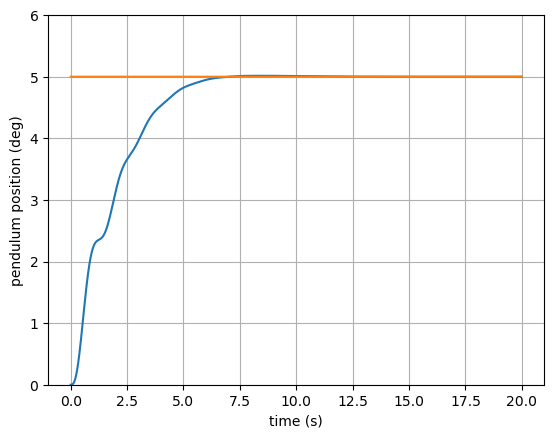

In [ ]:
plt.plot(time_vector, pendulum_angles)
plt.plot(time_vector, angle_des*np.ones((len(pendulum_angles))));
plt.xlabel('time (s)')
plt.ylabel('pendulum position (deg)');
plt.ylim(0, angle_des+1);
plt.grid()

In [ ]:
#| export
class Simulator():
    def __init__(self, pendulum, motor, controller):
        self._pendulum = pendulum
        self._motor = motor
        self._controller = controller
        self._data = defaultdict(list)
        
    def y_des(self, y):
        """Set the desired final position of the pendulum in degrees."""
        self.y_des = y
        
    def run(self, t0, tf, dt):
        time = np.arange(t0, tf, dt)

        for t in time:  
            u = self._controller.control(dt, y_des=np.radians(self.y_des), 
                                             y=self._pendulum.position())
            torque = self._motor.step(dt, u)
            self._pendulum.step(dt, u=torque)
                                        
            self._data['error (rad)'].append(np.radians(self.y_des) \
                                           - self._pendulum.position())
            self._data['position (rad)'].append(self._pendulum.position())
            self._data['speed (rad/s)'].append(self._pendulum.speed())
            self._data['torque (N.m)'].append(torque)
            
        self._data['time (s)'] = time
        return self._data
    

In [ ]:
pendulum = Pendulum(theta_0=np.radians(0), 
                    theta_dot_0=0, 
                    params=PendulumParameters(b=0.2))

motor = DCMotor(x0=np.array([[0], [0], [0]]), 
                params=DCMotorParams())

pid = PID(Kp=1000, 
          Kd=500, 
          Ki=1000)

# connect the motor to the pendulum
motor.connect_to(pendulum)

t0, tf, dt = 0, 20, 0.01
sim = Simulator(pendulum, motor, pid)
sim.y_des(10) # desired final value in degrees

results = sim.run(t0, tf, dt)

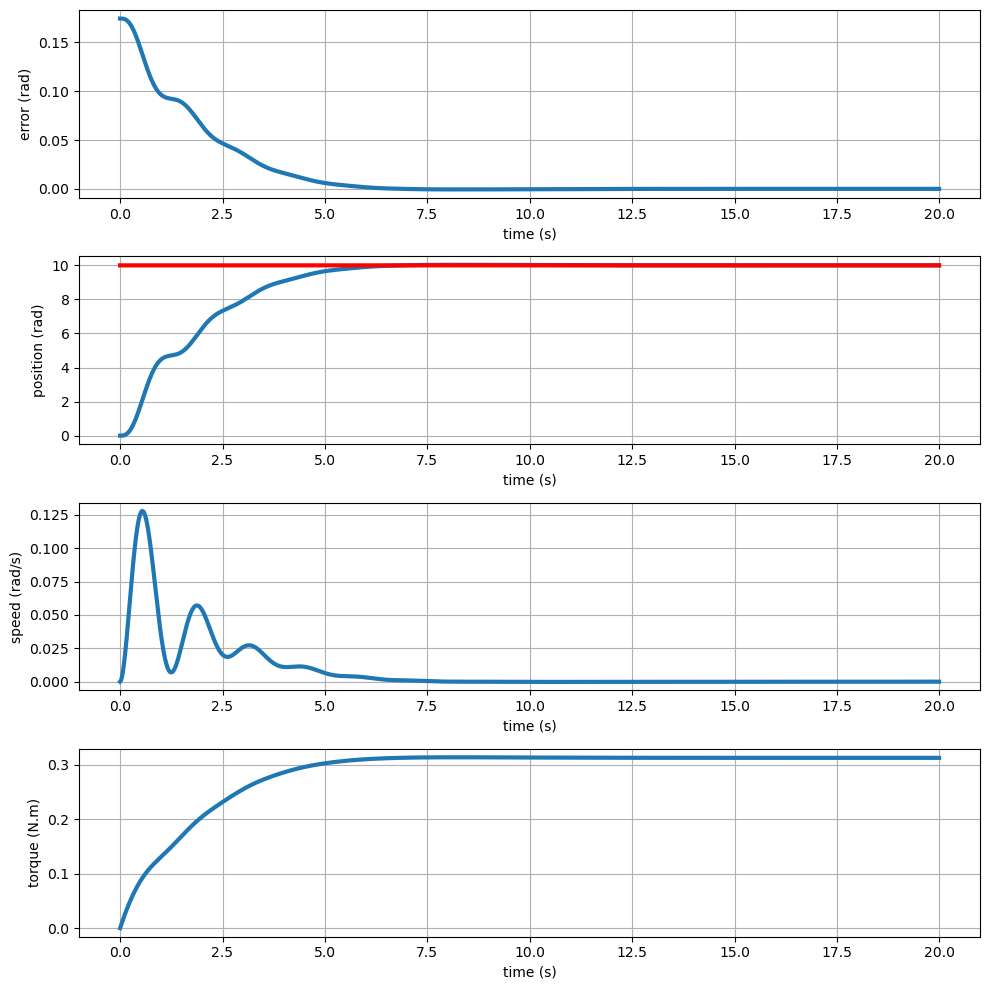

In [ ]:
fig, axs = plt.subplots(len(results.keys())-1, 1, figsize=(10,10))

for index, key in enumerate(results.keys()):
    if key == 'time (s)': continue
    if key == 'position (rad)':
        axs[index].plot(results['time (s)'], np.degrees(results[key]), linewidth=3)
        axs[index].plot(results['time (s)'], sim.y_des*np.ones(results['time (s)'].shape), color='r', linewidth=3)
    else:
        axs[index].plot(results['time (s)'], results[key], linewidth=3)
    axs[index].set_xlabel('time (s)')
    axs[index].set_ylabel(key)
    axs[index].grid()

    

plt.tight_layout()

## Animate

In [ ]:
#| export
class AnimateControlledPendulum():
    """See also: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/"""
    def __init__(self, sim):
        self._sim = sim
        
        self._fig = plt.figure()
        self._ax = self._fig.add_subplot(111, aspect='equal', autoscale_on=False,
                                 xlim=(-.5, .5), ylim=(-.5, 0))
        self._ax.grid()
        self._line, = self._ax.plot([], [], 'o-', lw=2)   
        
        self._title = self._ax.text(0.5, 1.05, "", #bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                    transform=self._ax.transAxes, ha="center")
        
    def animate_init(self):
        """Initialize animation.
           Plot the background of each frame. """
        self._line.set_data([], [])        
        return self._line,
            
    def animate(self, i):           
        """Animation function. 
           This is called sequentially to perform animation step"""                
        rod_end_1, rod_end_2 = self._sim._pendulum.rod_position_at(np.degrees(self._sim._data['position (rad)'][i]))
        self._line.set_data([rod_end_1[0], rod_end_2[0]], [rod_end_1[1], rod_end_2[1]])
        self._title.set_text(u"t = {:.1f}s".format(self._sim._data['time (s)'][i]))        
        return self._line, self._title
        
    def start_animation(self, t0, tf, dt):
        # choose the interval based on dt and the time to animate one step
        t_start = time.time()
        self.animate(0)
        t_end = time.time()
        interval = 1000 * dt - (t_end - t_start)
        n_frames = int((tf-t0)/dt)
        
        # call the animator. blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(self._fig, 
                                       self.animate, 
                                       init_func=self.animate_init,
                                       frames=n_frames, 
                                       interval=interval, 
                                       blit=True,
                                       repeat_delay=10000, 
                                       repeat=True);
        plt.close()
        return anim

In [ ]:
#%%capture
pendulum = Pendulum(theta_0=np.radians(0), 
                    theta_dot_0=0, 
                    params=PendulumParameters(b=0.2))

motor = DCMotor(x0=np.array([[0], [0], [0]]), 
                params=DCMotorParams())

pid = PID(Kp=1000, 
          Kd=500, 
          Ki=1000)

# connect the motor to the pendulum
motor.connect_to(pendulum)

t0, tf, dt = 0, 10, 1./30 # time
sim = Simulator(pendulum, motor, pid)

sim.y_des(10) # desired final value in degrees
results = sim.run(t0, tf, dt)

ap = AnimateControlledPendulum(sim)
ap.start_animation(t0, tf, dt)